<a href="https://colab.research.google.com/github/chandan9t8/GraphAlignment/blob/main/GraphAlignmentInitial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric
!pip install node2vec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from node2vec import Node2Vec
import networkx as nx
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
#Load data
g1_edgelist = pd.read_csv('./drive/MyDrive/Data/g1_edgelist.csv',names=['node1','node2'])
g2_edgelist = pd.read_csv('./drive/MyDrive/Data/g2_edgelist.csv',names=['node1','node2'])
anchors = pd.read_csv('./drive/MyDrive/Data/map_anchors.csv')

In [ ]:
#Generate graphs from pandas dataframe
G1 = nx.from_pandas_edgelist(g1_edgelist, 'node1', 'node2')
G2 = nx.from_pandas_edgelist(g2_edgelist, 'node1', 'node2')

# Convert to tensor
anchor_index = torch.tensor(anchors.values, dtype=torch.long)

In [ ]:
# Split the anchors into training and validation sets
train_idx, val_idx = train_test_split(range(len(anchor_index)), test_size=0.2, random_state=42)
train_anchors = anchor_index[train_idx]
val_anchors = anchor_index[val_idx]

In [ ]:
# Generate walks and train node2vec model
node2vec1 = Node2Vec(G1, dimensions=8, walk_length=10, num_walks=10, workers=4)
model1 = node2vec1.fit(window=10, min_count=1, batch_words=4)

node2vec2 = Node2Vec(G2, dimensions=8, walk_length=10, num_walks=10, workers=4)
model2 = node2vec2.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/4941 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Computing transition probabilities:   0%|          | 0/4941 [00:00<?, ?it/s]

In [ ]:
#extract the embeddings
embeddings1 = {node: model1.wv[str(node)] for node in G1.nodes()}
embeddings2 = {node: model2.wv[str(node)] for node in G2.nodes()}

In [ ]:
import json

embeddings1_serializable = {str(node): embeddings1[node].tolist() for node in G1.nodes()}
embeddings2_serializable = {str(node): embeddings2[node].tolist() for node in G2.nodes()}

# Store embeddings in a JSON file
with open('embeddings8_g1.json', 'w') as f:
    json.dump(embeddings1_serializable, f)

with open('embeddings8_g2.json', 'w') as f:
    json.dump(embeddings2_serializable, f)

In [ ]:
# Reload embeddings from JSON file
with open('embeddings8_g1.json', 'r') as f:
    embeddings1 = json.load(f)

with open('embeddings8_g2.json', 'r') as f:
    embeddings2 = json.load(f)

In [ ]:
#convert to tensors
x1 = torch.tensor([embeddings1[str(node)] for node in range(max(G1.nodes()) + 1)], dtype=torch.float)
x2 = torch.tensor([embeddings2[str(node)] for node in range(max(G2.nodes()) + 1)], dtype=torch.float)

In [ ]:
edge_index1 = torch.tensor(list(G1.edges), dtype=torch.long).t().contiguous()
edge_index2 = torch.tensor(list(G2.edges), dtype=torch.long).t().contiguous()

In [ ]:
graph1_data = Data(x1, edge_index=edge_index1)
graph2_data = Data(x2, edge_index=edge_index2)

In [ ]:
#model
# class GNN(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(GNN, self).__init__()
#         self.conv1 = GCNConv(input_dim, 16)
#         self.bn1 = nn.BatchNorm1d(16)
#         self.dropout1 = nn.Dropout(p=0.2)
#         self.conv2 = GCNConv(16, output_dim)
#         self.dropout2 = nn.Dropout(p=0.2)

#     def forward(self, x, edge_index):
#         x = F.relu(self.conv1(x, edge_index))
#         x = self.bn1(x)
#         x = self.dropout1(x)
#         x = F.relu(self.conv2(x, edge_index))
#         x = self.dropout2(x)
#         return x

class GNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, output_dim)  # Reduce to one layer to test impact
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.dropout1 = nn.Dropout(p=0.3)  # Slightly higher dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.dropout1(x)
        return x

class SiameseNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SiameseNet, self).__init__()
        self.gnn = GNN(input_dim, output_dim)

    def forward(self, data1, data2):
        # Pass both graph data through the same GNN
        emb1 = self.gnn(data1.x, data1.edge_index)
        emb2 = self.gnn(data2.x, data2.edge_index)
        return emb1, emb2

In [ ]:
def train(model, data1, data2, train_anchors, val_anchors, epochs,lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        emb1, emb2 = model(data1, data2)
        train_loss = loss_fn(emb1[train_anchors[:, 0]], emb2[train_anchors[:, 1]])

        # Penalty for already mapped nodes
        mapped_nodes_loss = loss_fn(emb1[anchor_index[:, 0]], emb2[anchor_index[:, 1]])

        # Total loss
        loss = loss + mapped_nodes_weight * mapped_nodes_loss


        train_loss.backward()
        optimizer.step()

        # Store the training loss
        train_losses.append(train_loss.item())

        # Validation phase
        model.eval()
        with torch.no_grad():
            emb1_val, emb2_val = model(data1, data2)
            val_loss = loss_fn(emb1_val[val_anchors[:, 0]], emb2_val[val_anchors[:, 1]])
            # Store the validation loss
            val_losses.append(val_loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Train Loss {train_loss.item()} Val Loss {val_loss.item()}")

    return train_losses, val_losses, train_losses[-1],val_losses[-1],model

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
#hyperparameter tuning

import numpy as np

learning_rates = [0.003, 0.0001, 0.0003,0.00003]
epoch_options = [100,500,1000,10000]
best_train_loss = np.inf
best_val_loss = np.inf
best_params = None
best_model = None

for lr in learning_rates:
    for epochs in epoch_options:
        print(f"Testing LR={lr}, Epochs={epochs}")
        model = SiameseNet(input_dim=8, output_dim=8)
        train_losses, val_losses, last_train_loss,last_val_loss, trained_model = train(model, graph1_data, graph2_data, train_anchors, val_anchors, epochs, lr)

        if last_val_loss < best_val_loss:
            best_val_loss = last_val_loss
            best_train_loss = last_train_loss
            best_params = {'lr': lr, 'epochs': epochs}
            best_model = trained_model
            print(f"New best found: LR={lr}, Epochs={epochs}, Val Loss={last_val_loss}")

print("Best Parameters:", best_params)
print("Best Validation Loss:", best_val_loss)

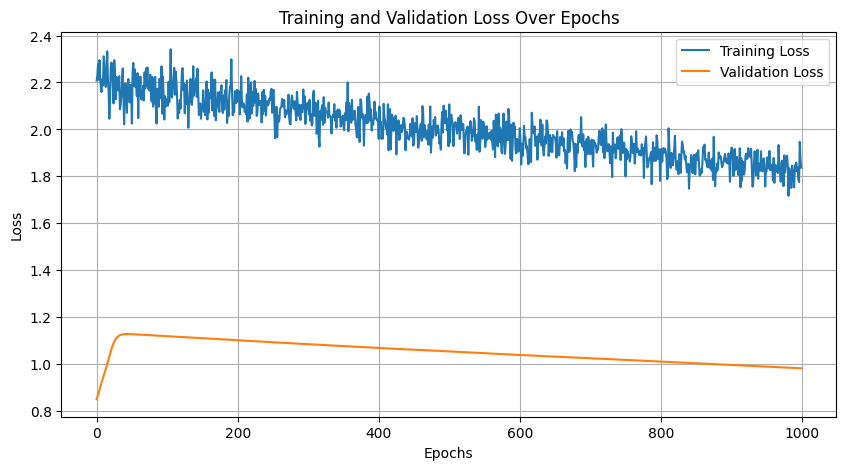

In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
print(best_params['lr'], best_params['epochs'])

0.003 1000


In [ ]:
# Reinitialize the model and train on the entire dataset
best_model = SiameseNet(8, 8)
best_model.train()

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'])
#optimizer = torch.optim.Adam(trained_model.parameters(), lr=0.0003)
loss_fn = torch.nn.MSELoss()

for epoch in range(best_params['epochs']):
    optimizer.zero_grad()
    emb1, emb2 = best_model(graph1_data, graph2_data)
    train_loss = loss_fn(emb1[train_anchors[:, 0]], emb2[train_anchors[:, 1]])
    train_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss {train_loss.item()}")

Epoch 0: Train Loss 2.4805188179016113
Epoch 100: Train Loss 0.28915107250213623
Epoch 200: Train Loss 0.07732205837965012
Epoch 300: Train Loss 0.026830239221453667
Epoch 400: Train Loss 0.015368483029305935
Epoch 500: Train Loss 0.009673015214502811
Epoch 600: Train Loss 0.006927479989826679
Epoch 700: Train Loss 0.00387266231700778
Epoch 800: Train Loss 0.0026948198210448027
Epoch 900: Train Loss 0.0018044369062408805


In [ ]:
def predict_correspondences(model, data1, data2):
    model.eval()
    with torch.no_grad():
        emb1, emb2 = model(data1, data2)

    # Normalize embeddings to unit vectors for cosine similarity
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)

    # Compute cosine similarity and predict correspondences
    similarity = torch.matmul(emb1, emb2.t())
    predicted_correspondences = similarity.argmax(dim=1)

    # Create a dictionary mapping each node in graph1 to a node in graph2
    correspondence_dict = {i: predicted_correspondences[i].item() for i in range(data1.num_nodes)}

    return correspondence_dict

predicted_correspondences = predict_correspondences(best_model, graph1_data, graph2_data)

In [ ]:
import csv

with open('Node_mappings_final.csv', 'w', newline='') as csvfile:
    fieldnames = ['g1', 'g2']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for node_g1, node_g2 in predicted_correspondences.items():
        writer.writerow({'g1': node_g1, 'g2': node_g2})